**Definición del problema**

Dado un conjunto de datos históricos con información que incluye información como la duración del sueño y las actividades físicas de las personas, Se busca determinar si el paciete la tendencia a padecer Trastornos del Sueño.

**Por lo tanto estamos ante un problema de clasificación Multiclase al ser un valor que puede ser un valor en porcentaje.**

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import pandas as pd
import keras
from keras.utils import FeatureSpace
import matplotlib.pyplot as plt

**Preparar la Infomación**

In [ ]:
#Montar el drive
from google.colab import drive
drive.mount('/content/drive')

dataframe  = pd.read_csv('/content/drive/MyDrive/IA-Clase/Health_Sleep_Statistics.csv')

#Eliminamos la columna id que no es significativa para nuestro problema
dataframe = dataframe.drop('User ID', axis=1)

# Convertirmos la columna de diagnostico a un formato binario para facilitar su estructura
dataframe['Sleep Disorders'] = dataframe['Sleep Disorders'].map({'no': 0, 'yes': 1})
dataframe['Medication Usage'] = dataframe['Medication Usage'].map({'no': 0, 'yes': 1})
dataframe['Gender'] = dataframe['Gender'].map({'f': 0, 'm': 1})
dataframe['Physical Activity Level'] = dataframe['Physical Activity Level'].map({ "low": 0,"medium": 1,"high":2})

dataframe.head()

Mounted at /content/drive


,Age,Gender,Sleep Quality,Bedtime,Wake-up Time,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage
0,25,0,8,23:00,06:30,8000,2500,1,healthy,0,0
1,34,1,7,00:30,07:00,5000,2200,0,unhealthy,1,1
2,29,0,9,22:45,06:45,9000,2700,2,healthy,0,0
3,41,1,5,01:00,06:30,4000,2100,0,unhealthy,1,0
4,22,0,8,23:30,07:00,10000,2800,2,medium,0,0


Dividir los datos en entrenamiento y validación

In [ ]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 1402 samples for training and 351 for validation


In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Sleep Disorders")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)


Cada conjunto de datos produce una tupla (entrada, diagnostico) donde la entrada es un diccionario de características y el objetivo es el valor no(0) o yes(1).


In [ ]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Sleep Disorders:", y)

Input: {'Age': <tf.Tensor: shape=(), dtype=int64, numpy=18>, 'Gender': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'Sleep Quality': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'Bedtime': <tf.Tensor: shape=(), dtype=string, numpy=b'07:50'>, 'Wake-up Time': <tf.Tensor: shape=(), dtype=string, numpy=b'15:30'>, 'Daily Steps': <tf.Tensor: shape=(), dtype=int64, numpy=9438>, 'Calories Burned': <tf.Tensor: shape=(), dtype=int64, numpy=1917>, 'Physical Activity Level': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Dietary Habits': <tf.Tensor: shape=(), dtype=string, numpy=b'healthy'>, 'Medication Usage': <tf.Tensor: shape=(), dtype=int64, numpy=0>}
Sleep Disorders: tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
#Agrupamos los datasets
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

**Configuración de un FeatureSpace**
Para configurar cómo debe preprocesarse cada característica, instanciamos un keras.utils.FeatureSpace y le pasamos un diccionario que mapea el nombre de nuestras características a una cadena que describe el tipo de característica.

In [ ]:
from keras.utils import FeatureSpace

feature_space = FeatureSpace(
    features={
        "Age": FeatureSpace.float_normalized(),  # Edad como valor numérico normalizado
        "Gender": FeatureSpace.integer_categorical(),  # Género como categórica numérica
        "Sleep Quality": FeatureSpace.integer_categorical(),  # Calidad del sueño como categórica numérica
        "Bedtime": FeatureSpace.string_hashed(num_bins=100),  # Hora de acostarse como hashed string
        "Wake-up Time": FeatureSpace.string_hashed(num_bins=100),  # Hora de despertar como hashed string
        "Daily Steps": FeatureSpace.float_normalized(),  # Pasos diarios como numérica normalizada
        "Calories Burned": FeatureSpace.float_normalized(),  # Calorías quemadas como numérica normalizada
        "Physical Activity Level": FeatureSpace.integer_categorical(),  # Nivel de actividad física como categórica numérica
        "Dietary Habits": FeatureSpace.string_hashed(num_bins=50),  # Hábitos alimenticios como hashed string
        "Medication Usage": FeatureSpace.integer_categorical()  # Uso de medicamentos como categórica numérica
    },
    output_mode="concat",
)

**Adaptar el FeatureSpace a los datos de entrenamiento**


In [ ]:
train_ds_with_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)



In [ ]:
for x, _ in train_ds.take(1):
    preprocessed_x = feature_space(x)
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (32, 274)
preprocessed_x.dtype: <dtype: 'float32'>


In [ ]:
preprocessed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

preprocessed_val_ds = val_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)

**Construir un modelo/Optimizador adam**

In [ ]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()

x = keras.layers.Dense(32, activation="relu")(encoded_features)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(1, activation="sigmoid")(x)

training_model = keras.Model(inputs=encoded_features, outputs=predictions)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)

**Entrenar el modelo**

In [ ]:
training_model.fit(
    preprocessed_train_ds,
    epochs=10,
    validation_data=preprocessed_val_ds,
    verbose=2,
)

Epoch 1/10
44/44 - 2s - 34ms/step - accuracy: 0.5913 - loss: 0.6725 - val_accuracy: 0.6610 - val_loss: 0.6318
Epoch 2/10
44/44 - 0s - 8ms/step - accuracy: 0.7040 - loss: 0.5998 - val_accuracy: 0.6695 - val_loss: 0.5864
Epoch 3/10
44/44 - 0s - 6ms/step - accuracy: 0.7026 - loss: 0.5570 - val_accuracy: 0.6838 - val_loss: 0.5517
Epoch 4/10
44/44 - 0s - 6ms/step - accuracy: 0.7240 - loss: 0.5253 - val_accuracy: 0.7009 - val_loss: 0.5287
Epoch 5/10
44/44 - 0s - 5ms/step - accuracy: 0.7282 - loss: 0.5151 - val_accuracy: 0.7094 - val_loss: 0.5123
Epoch 6/10
44/44 - 0s - 5ms/step - accuracy: 0.7454 - loss: 0.4958 - val_accuracy: 0.7066 - val_loss: 0.5025
Epoch 7/10
44/44 - 0s - 7ms/step - accuracy: 0.7689 - loss: 0.4757 - val_accuracy: 0.7037 - val_loss: 0.4937
Epoch 8/10
44/44 - 0s - 5ms/step - accuracy: 0.7504 - loss: 0.4741 - val_accuracy: 0.7123 - val_loss: 0.4867
Epoch 9/10
44/44 - 0s - 7ms/step - accuracy: 0.7639 - loss: 0.4613 - val_accuracy: 0.7208 - val_loss: 0.4825
Epoch 10/10
44/44 

**OJO Funcion para Graficos**

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(predictions):
    """
    Método para generar un gráfico de barras con las predicciones de los pacientes.
        Parámetros:
     - predictions: lista de las predicciones (probabilidades) correspondientes a cada paciente.
    """

    patients = ["Paciente #1", "Paciente #2"]
    # Crear el gráfico de barras
    plt.figure()
    plt.bar(patients, predictions, color=['Black', 'Green'])

    # Agregar etiquetas y título
    plt.ylim(0, 100)  # Límite de la probabilidad en %
    plt.ylabel("Probabilidad (%)", fontsize=12)
    plt.title("Probabilidad de Padecer Trastorno del Sueño", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Mostrar el valor de cada barra
    for i, prob in enumerate(predictions):
        plt.text(i, prob + 1, f"{prob:.2f}%", ha='center', fontsize=10)

    # Mostrar la gráfica
    plt.show()


**Prueba con datos**

La primera muestra es de una persona con Trastornos del sueño
 la segunda sano**



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Esta paciente #1  en particular tiene un 91.00% Probabilidad De padecer Trastorno del Sueño, según lo evaluado por nuestro modelo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Esta paciente #2  en particular tiene un 30.58% Probabilidad De padecer Trastorno del Sueño, según lo evaluado por nuestro modelo


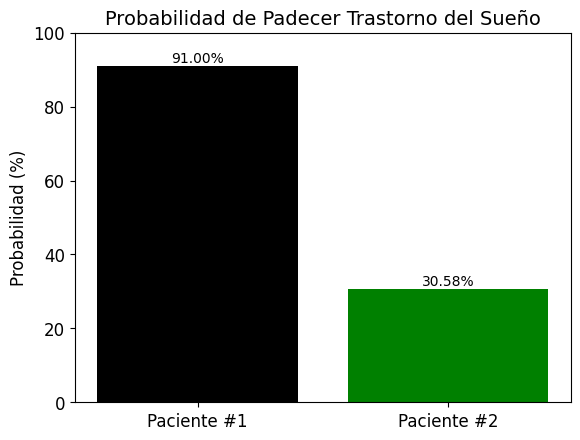

In [ ]:
# 34,m,7, 00:30, 07:00,5000,2200,low:0,unhealthy,yes,yes
""""
CARACTERISTICAS
Age,Gender,Bedtime,Wake-up Time,Daily Steps,Calories Burned,
Physical Activity Level,Dietary Habits,Medication Usage
"""
sample = {
        "Age": 34,
        "Gender": 0,
        "Sleep Quality": 7,
        "Bedtime": '00:30',
        "Wake-up Time": '07:00',
        "Daily Steps": 5000,
        "Calories Burned": 2200,
        "Physical Activity Level":0 ,
        "Dietary Habits": 'unhealthy',
        "Medication Usage":1,
}
#30,f:0,8,22:30,06:00,8500,2600,high:2,healthy,no
sample2 = {
     "Age": 30,
        "Gender": 0,
        "Sleep Quality": 8,
        "Bedtime": '22:30',
        "Wake-up Time": '06:00',
        "Daily Steps": 8500,
        "Calories Burned": 2600,
        "Physical Activity Level":2,
        "Dietary Habits": 'healthy',
        "Medication Usage":1,
}
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions1 = inference_model.predict(input_dict)  * 100

print(
    f"Esta paciente #1  en particular tiene un {predictions1[0][0]:.2f}% Probabilidad "
    "De padecer Trastorno del Sueño, según lo evaluado por nuestro modelo"
)

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample2.items()}
predictions2 = inference_model.predict(input_dict) *100

print(
    f"Esta paciente #2  en particular tiene un {predictions2[0][0]:.2f}% Probabilidad "
    "De padecer Trastorno del Sueño, según lo evaluado por nuestro modelo"
)

predictions = [predictions1[0][0], predictions2[0][0]]

plot_predictions(predictions)

**Construir un modelo/Optimizador SGD**

In [ ]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()

x = keras.layers.Dense(32, activation="relu")(encoded_features)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(1, activation="sigmoid")(x)

training_model = keras.Model(inputs=encoded_features, outputs=predictions)
training_model.compile(
    optimizer="SGD", loss="binary_crossentropy", metrics=["accuracy"]
)

inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)

**Entrenar el modelo**

In [ ]:
training_model.fit(
    preprocessed_train_ds,
    epochs=20,
    validation_data=preprocessed_val_ds,
    verbose=2,
)

Epoch 1/20
44/44 - 1s - 32ms/step - accuracy: 0.5485 - loss: 0.7280 - val_accuracy: 0.5442 - val_loss: 0.6983
Epoch 2/20
44/44 - 0s - 9ms/step - accuracy: 0.5934 - loss: 0.6642 - val_accuracy: 0.5527 - val_loss: 0.6570
Epoch 3/20
44/44 - 0s - 6ms/step - accuracy: 0.6170 - loss: 0.6348 - val_accuracy: 0.6296 - val_loss: 0.6280
Epoch 4/20
44/44 - 0s - 8ms/step - accuracy: 0.6427 - loss: 0.6020 - val_accuracy: 0.6496 - val_loss: 0.6059
Epoch 5/20
44/44 - 0s - 7ms/step - accuracy: 0.6434 - loss: 0.5859 - val_accuracy: 0.6667 - val_loss: 0.5883
Epoch 6/20
44/44 - 0s - 4ms/step - accuracy: 0.6591 - loss: 0.5805 - val_accuracy: 0.6923 - val_loss: 0.5748
Epoch 7/20
44/44 - 0s - 4ms/step - accuracy: 0.6726 - loss: 0.5601 - val_accuracy: 0.7037 - val_loss: 0.5635
Epoch 8/20
44/44 - 0s - 7ms/step - accuracy: 0.6683 - loss: 0.5549 - val_accuracy: 0.7009 - val_loss: 0.5545
Epoch 9/20
44/44 - 0s - 4ms/step - accuracy: 0.6790 - loss: 0.5448 - val_accuracy: 0.7009 - val_loss: 0.5468
Epoch 10/20
44/44 

**Prueba con datos Nuevamente con Sample y Sample2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Esta paciente #1  en particular tiene un 91.00% Probabilidad De padecer Trastorno del Sueño, según lo evaluado por nuestro modelo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Esta paciente #2  en particular tiene un 30.58% Probabilidad De padecer Trastorno del Sueño, según lo evaluado por nuestro modelo


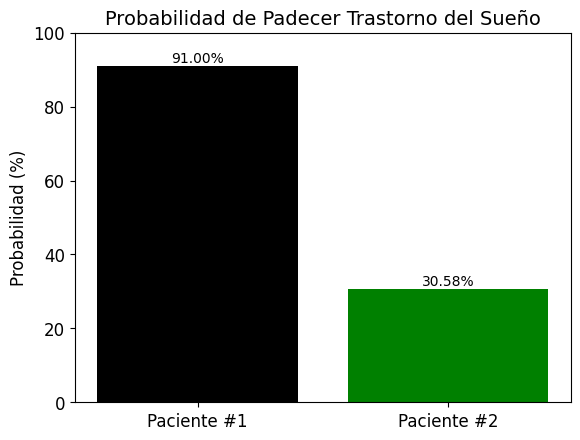

In [ ]:
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions1 = inference_model.predict(input_dict)  * 100

print(
    f"Esta paciente #1  en particular tiene un {predictions1[0][0]:.2f}% Probabilidad "
    "De padecer Trastorno del Sueño, según lo evaluado por nuestro modelo"
)

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample2.items()}
predictions2 = inference_model.predict(input_dict) *100

print(
    f"Esta paciente #2  en particular tiene un {predictions2[0][0]:.2f}% Probabilidad "
    "De padecer Trastorno del Sueño, según lo evaluado por nuestro modelo"
)
predictions = [predictions1[0][0], predictions2[0][0]]
plot_predictions(predictions)


# **Conclusiones (Respuesta a la pregunta del Cliente)**

Se concluye que el paciente #1 tiene probabilidades altas de Padecer de Trastornos del Sueño,

En cambio el paciente #2 no padece de trastornos del sueño son Menores sus posibilidades